# Modeling Condenser Water Supply Temperature (CWSHDR) of INSEAD plant with standard regression techniques 

## A thought experiment.

CWSHDR is a timeseries and seasonal patterns can be observed looking at the data. However, the proposition is that Chiller Plants ideally follow the principles of theromodynamics and as such the the parameters logged by sensors demonstrate linear or non-linear relationship. And within a small time period during which seasonal patterns are irrelevant, standard regressions model be able to capture the physical properties of this system.

## A quick look into the data

The below plots represent data from INSEAD Chiller Plant recorded on 17th May, 2017. Some zeros / null values may have been ignored to highlight the big-picture. These plots have been generated using Tableau.

### CWSHDR vs. Time (hours)

You would notice that as the day progresses, there is an increase in CWSHDR value and again reducing as the next day approaches. This trend can be noticed in the entire dataset and other chiller plants as well. Perhaps, this behavior can be attributed to "business hours" of the buildings.

![images.png](images/1.png)

### CWSHDR vs. Drybulb.

1. Each color represents an hour (0-23) of 24 hours. Notice that data points of each hour form a cluster! 
2. You could generally notice a up-ward increase of CWSHDR as Drybulb value increases

![image.png](images/2.png)

Let's look at the **entire data set (approx 8 months)**. Does the above listed charactersitcs satisfy? Well, yes indeed! 
![image.png](images/3.png)

### CWSHDR vs. Rh

There is an downward trend with relative humidity while we observe an upward trend with Drybulb. *All these plots especially this appears to be heteroskedastic.*

![image.png](images/4.png)

### CWSHDR vs. Loadsys

Coming back to the initial sample (one day data), we can notice an upward trend

![image.png](images/5.png)

### CWSHDR vs. (CT1KW, CT2AKW)

I don't immediately read any observations that would help in modeling. However, its noticeable that one of the cooling tower is working while the other is shutdown (0KW power). This could be used in regression modeling. My assumptions is that each cooling tower may respond to its Inputs differently. Let's keep this in mind and take a look into how the regression's accuracy changes when the optimizer is given which cooling tower is working.. 

![image.png](images/6.png)

### CWSHDR vs. CWRHDR
The relationship seems obvious like in the above plots. A upward trend.

![image.png](images/7.png)

## Load data

Note: My hunch is that Decision Tree would be able to capture the Hour vs. {CWSHDR, Drybulb, Rh, CTKW} properties. So, an ensemble model could improve the accuracy.. Anyway, let's experiment these stuff. But before, let's load the data!!

In [16]:
%matplotlib inline

import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import numpy as np
import glob
import os

from sklearn import linear_model
from sklearn import metrics
from sklearn import preprocessing

In [17]:
def load_df(src, pattern):
    all_files = glob.glob(os.path.join(src, pattern))
    df = pd.concat([pd.read_csv(f, low_memory=False) for f in all_files], ignore_index=True)

    # minor changes
    df = df.rename(columns={"Time Stamp": "timestamp"})
    df = df.replace("\\N", np.nan)

    # update data types. object is taken as default
    dtypes = dict([(col, np.float64) for col in df.columns])
    dtypes["timestamp"] = "datetime64[ns]"
    df = df.astype(dtypes)

    # change the index to timestamp.
    df.index = df.timestamp
    
    return df


# load all csv files of North-point site. Concatenate them..
data_src = "../data/insead"
pattern = "*21*.csv" # don't want to load all data (500MB or more!)
df = load_df(data_src, pattern)

In [18]:
print((df<0).sum()*100/df.count())

timestamp       0.000000
chwrhdr         0.000000
chwshdr         0.015236
chwsfhdr        0.000000
cwshdr          0.000000
cwrhdr          0.000000
cwsfhdr         0.029087
ch1kw           0.000000
ch2kw           0.000000
ch3kw           0.000000
chwp1kw         0.000000
chwp2kw         0.000000
chwp3kw         2.156584
chwp4kw         9.131117
cwp1kw          0.000346
cwp2kw          0.000000
cwp3kw         44.370976
ct1kw           0.000000
ct2akw          0.000000
incomingkw1     0.000000
incomingkw2     0.000000
rh              0.000693
drybulb         0.000000
chiller_eff     0.361162
cwp_eff         0.361162
chwp_eff        0.361162
ct_eff          0.361162
chwgpmrt        0.356661
cwgpmrt         0.363932
systotpower     0.000000
loadsys         0.354929
effsys          0.358046
hbsys          29.694241
dtype: float64


## Preprocessing

In [3]:
# Percentage of null values..
(df.count() * 100)  / df.timestamp.count()

timestamp      100.000000
chwrhdr        100.000000
chwshdr        100.000000
chwsfhdr       100.000000
cwshdr         100.000000
cwrhdr         100.000000
cwsfhdr        100.000000
ch1kw          100.000000
ch2kw          100.000000
ch3kw          100.000000
chwp1kw        100.000000
chwp2kw        100.000000
chwp3kw        100.000000
chwp4kw         99.978185
cwp1kw         100.000000
cwp2kw         100.000000
cwp3kw          99.501368
ct1kw          100.000000
ct2akw          99.989958
incomingkw1     99.978185
incomingkw2     99.978185
rh              99.978877
drybulb         99.978877
chiller_eff    100.000000
cwp_eff        100.000000
chwp_eff       100.000000
ct_eff         100.000000
chwgpmrt       100.000000
cwgpmrt        100.000000
systotpower    100.000000
loadsys        100.000000
effsys         100.000000
hbsys          100.000000
dtype: float64

You'd notice above there are some null values in the columns we are interested. i.e, Drybulb, Rh, Ct2akw. But there are not too many. So, I'll drop respective data points from the dataset. Anyway, were not viewing this data as timeseries.

In [12]:
# select the interested features.. 
data = df[ ["cwshdr", "loadsys", "drybulb", "ct1kw", "ct2akw", "rh", "cwrhdr", "systotpower", "cwsfhdr"] ].dropna()
data.describe()

,cwshdr,loadsys,drybulb,ct1kw,ct2akw,rh,cwrhdr,systotpower,cwsfhdr
count,288701.000000,288701.000000,288701.000000,288701.000000,288701.000000,288701.000000,288701.000000,288701.000000,288701.000000
mean,27.394906,251.938826,27.964800,4.224875,3.550149,86.280931,30.657210,140.409952,1086.887573
std,1.315870,152.731074,2.024122,3.062855,2.827426,7.229243,2.221389,80.542155,500.570411
min,0.000000,-499.065000,0.000000,0.000000,0.000000,-15.677400,0.000000,0.000000,-19.292500
25%,26.589000,94.808300,26.400000,3.904000,0.010000,81.791700,29.161800,58.904200,599.829000
50%,27.539600,236.154000,27.800000,4.672000,3.728000,87.703300,31.119900,125.851000,914.755000
75%,28.307100,394.036000,29.300000,5.056000,4.512000,91.676900,32.352900,213.653000,1538.700000
max,32.878900,998.501000,34.300000,24.832000,23.552000,99.217800,40.004600,507.597000,2837.570000


In [19]:
# Number of zeros. Zeros could mean nothing...? 
# Basic regression models can respond to these zeros pretty aggresively. So, what should we do?
#
# Case 1: If the sudden drop to approx. 0 stays for a very-short period, it shouldn't be 0?
# Case 2: If the sudden drop to approx. 0 stays for a very-long period, the system is shut down? 
# Case 3: Is it okay to have -ve values?
print((data<0).sum())

# Let's make values below the threshold (defined above) 0. Assuming "system shut-down"
data.loadsys[data.loadsys < 0] = 0
data.rh[data.rh < 0 ] = 0

cwshdr         0
loadsys        0
drybulb        0
ct1kw          0
ct2akw         0
rh             0
cwrhdr         0
systotpower    0
cwsfhdr        0
hour           0
minute         0
hour_sqr       0
minute_sqr     0
dtype: int64


In [20]:
# preparing some extra features.
data["hour"] = data.index.hour
data["minute"] = data.index.minute
data["hour_sqr"] = data.hour.apply(lambda x: x**2)
data["minute_sqr"] = data.minute.apply(lambda x: x**2)

In [21]:
# normalize the data
def get_normalized_df(dataframe, scale=(0,1), columns=None):
    # columns and index
    columns = columns or dataframe.columns
    index = dataframe.index.values
    
    # fit the scaler
    scaler = preprocessing.MinMaxScaler(scale)
    dataframe = pd.DataFrame(scaler.fit_transform(dataframe), columns=columns, index=index)
    
    # attach the scaler..
    dataframe.scaler = scaler
    return dataframe

# Note: Sometimes, scikit-learn isn't really rescaling in the intended way. Check whether histograms of pre-scaled
# and scaled data match.
data = get_normalized_df(data)

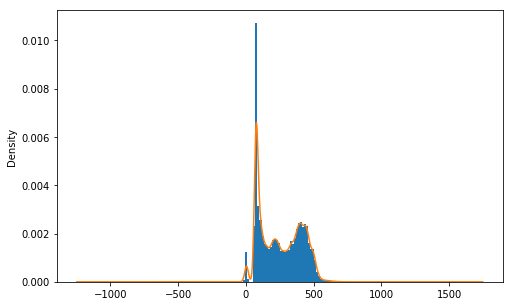

In [20]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
df.loadsys.plot.hist(ax=ax, bins=100, normed=True)
df.loadsys.plot.kde(ax=ax)
#ax.set_xlim(20,35)

## Training the regression models

In [22]:
mean_absolute_error_percent = lambda y_true, y_pred: np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
def mean_absolute_error_percent_noinf(y_true, y_predict):
    cnt = 0
    tot_err = 0
    for i in range(y_true.shape[0]):
        if y_true[i] != 0:
            tot_err += np.abs((y_true[i] - y_predict[i]) / y_true[i])
            cnt += 1
    return (tot_err / cnt) * 100

In [25]:
# take the sample we're interested in.
train = data["2017-05-17":"2017-05-17"]  # Train on this day
test = data["2017-05-18":"2017-05-18"] # Test on the next day

# consider the target and features for training
features = ["loadsys", "drybulb", "rh", "cwrhdr"]
target = "cwshdr"

# fit the model
reg = linear_model.LinearRegression()
reg.fit(train[features].values, train[target].values)

# check the metrics
y_predict = reg.predict(test[features].values)
y_test = test[target].values
print("MSE: ", metrics.mean_squared_error(y_test, y_predict))
print("Variance score: ", metrics.explained_variance_score(y_test, y_predict), "(1 is the best)")
print("R Squared score: ", reg.score(test[features].values, test[target].values))
print("Coef: ", reg.coef_)
print("Intercept: ", reg.intercept_)

# 5% or 10% error is where we are looking at.. 
print("MAPE (no inf): ", mean_absolute_error_percent_noinf(y_test, y_predict))
print("MAPE: ", mean_absolute_error_percent(y_test, y_predict))

MSE:  1.58435255241e-05
Variance score:  0.967213295786 (1 is the best)
R Squared score:  0.967156138504
Coef:  [ 0.01109797  0.37828137  0.21090522  0.44560308]
Intercept:  0.0020854139575
MAPE (no inf):  0.326380988359
MAPE:  0.326380988359


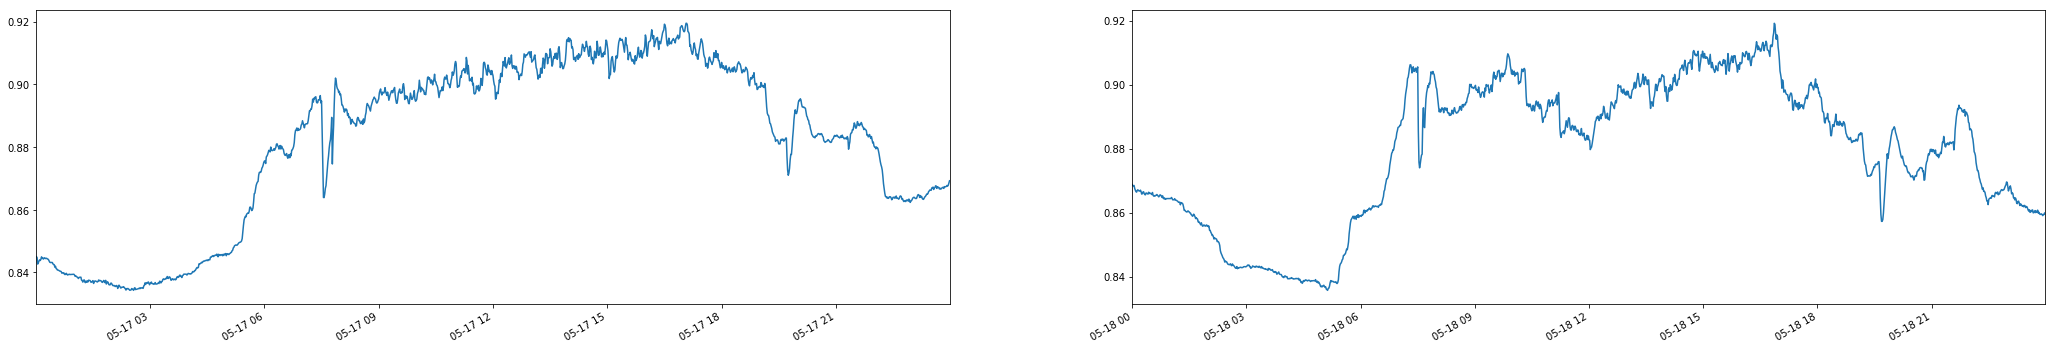

In [26]:
# let's see the training and test data first..
fig, (a1, a2) = plt.subplots(1,2, figsize=(36,6))
train.cwshdr[1:].plot(ax=a1) ## ignore first value 0, for better representation. we could change axis instead.
test.cwshdr.plot(ax=a2)

## Observations
1. Removing CT1KW, CT2AKW has improved variance score by 0.30. Is this because the values haven't been preprocessed properly? Need to really come to good conclusion / proper plan on this.

2. My initial assumption that the data is proportional to $hours^2$ and $minute^2$ (poly regression) has not produced good results. The assumption is based on the empirical observation that CWSHDR looks approx. like a parabola. Hours and Minute data appared to be good indicators for the 2nd-degree polynomial in this case.. The variance doesn't decrease even after removing these features.

## Plot the prediction

(0.8, 0.93)

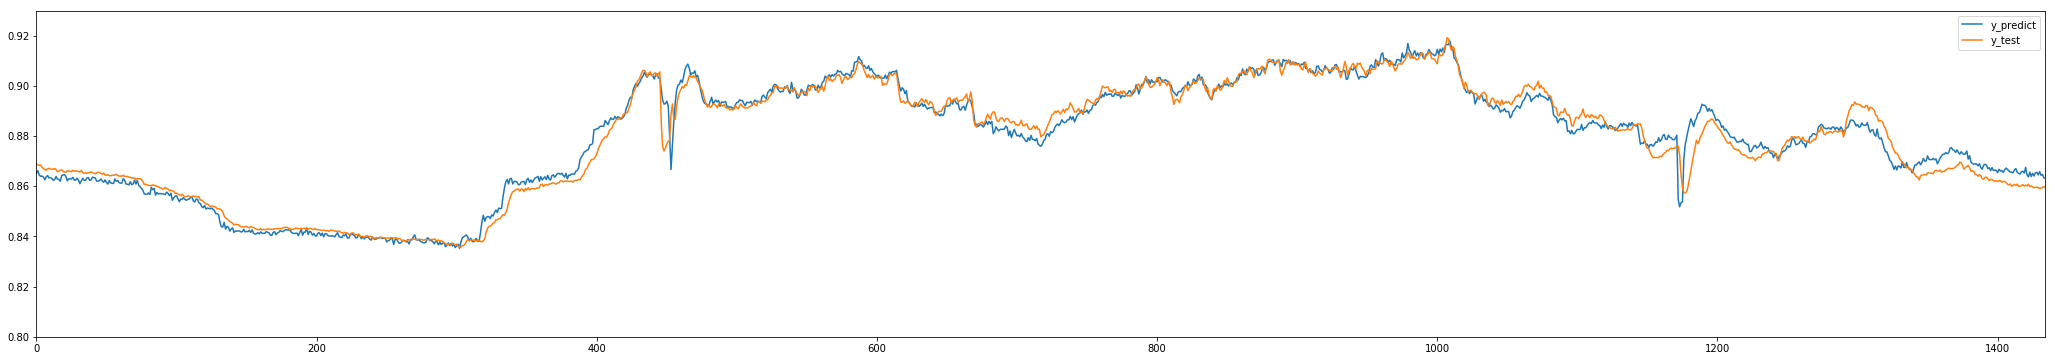

In [27]:
df_plot = pd.DataFrame({"y_test": y_test, "y_predict": y_predict})
fig, ax = plt.subplots(1, 1, figsize=(36,6))
df_plot.plot(ax=ax)
ax.set_ylim(0.8, 0.93)

**Interesting! Linear regression really captured the general big-picture charactersitcs of the model. Can we use this as an intermediate step for tuning?** However, where did this linear model made incorrect decisions? Let's look at those first.

## Let's test this model on several samples..

Starting with 17th May, 2017 for the next 30 days, the linear model is iteratively trained with a day's data and tested with corresponding next day's data. I.e, 
```
For each day in (30 days):
   - Train this day's data
   - Test with next day's data
```

Train:  2017-05-17 Test:  2017-05-18 Error:  0.286887359224
Train:  2017-05-18 Test:  2017-05-19 Error:  0.250842425919
Train:  2017-05-19 Test:  2017-05-20 Error:  0.369280973507
Train:  2017-05-20 Test:  2017-05-21 Error:  0.400044355699
Train:  2017-05-21 Test:  2017-05-22 Error:  0.24799932208
Train:  2017-05-22 Test:  2017-05-23 Error:  0.308694726865
Train:  2017-05-23 Test:  2017-05-24 Error:  0.541974322154
Train:  2017-05-24 Test:  2017-05-25 Error:  0.273930830428
Train:  2017-05-25 Test:  2017-05-26 Error:  0.408350445431
Train:  2017-05-26 Test:  2017-05-27 Error:  0.379220751195
Train:  2017-05-27 Test:  2017-05-28 Error:  0.419287179682
Train:  2017-05-28 Test:  2017-05-29 Error:  0.948175717679
Train:  2017-05-29 Test:  2017-05-30 Error:  0.528835061719
Train:  2017-05-30 Test:  2017-05-31 Error:  0.46124951505
Train:  2017-05-31 Test:  2017-06-01 Error:  0.308005618957
Train:  2017-06-01 Test:  2017-06-02 Error:  0.371803162763
Train:  2017-06-02 Test:  2017-06-03 Error

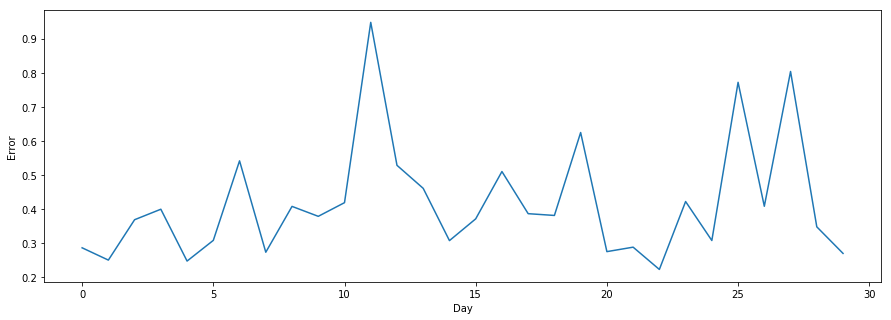

In [72]:
# data := data, numpy nd array.
# start := dt.date object
# period := # of consecutive datys to test
def run(data, start, period):
    err_list = []

    # starting date
    start_date = start
    
    for _ in range(period):
        # select the dates. Train with data of day N, test on N+1 day.
        date_train = start_date.strftime("%Y-%m-%d")
        date_test = (start_date + dt.timedelta(days=1)).strftime("%Y-%m-%d")
    
        # take the sample we're interested in.
        train = data[date_train:date_train]  # Train on this day
        test = data[date_test:date_test] # Test on the next day
        
        # fit the model
        reg = linear_model.LinearRegression()
        reg.fit(train[features].values, train[target].values)

        # Log the metrics
        y_predict = reg.predict(test[features].values)
        y_test = test[target].values
        err_list.append(mean_absolute_error_percent_noinf(y_test, y_predict))
        
        print("Train: ", start_date, "Test: ", start_date + dt.timedelta(1), "Error: ", err_list[-1])
    
        # update the start date
        # NOTE: This worked well without updating the start date. That means
        # there has to be something with selecting "good" dataset for training..
        start_date = start_date + dt.timedelta(days=1)
        
    return err_list



err_list = run(data=data, start=dt.date(2017,5,17), period=30)
fig, ax = plt.subplots(1, 1, figsize=(15,5))
ax.plot(err_list); ax.set_xlabel("Day"); ax.set_ylabel("Error");

**Why are there sudden increase in errors?**

MSE:  9.46823451929e-05
Variance score:  0.912584895506 (1 is the best)
R Squared score:  0.847935238439
Error Percent:  0.878620454954


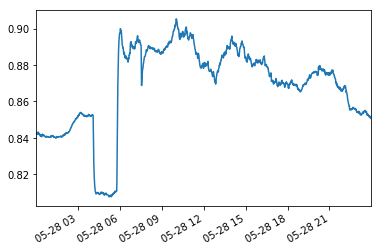

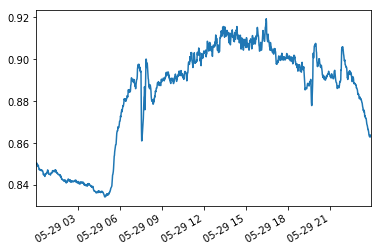

In [73]:
train = data["2017-05-28":"2017-05-28"]
test = data["2017-05-29":"2017-05-29"]

reg = linear_model.LinearRegression()
reg.fit(train[features].values[1:], train[target].values[1:])

y_predict = reg.predict(test[features].values)
y_test = test[target].values

print("MSE: ", metrics.mean_squared_error(y_test, y_predict))
print("Variance score: ", metrics.explained_variance_score(y_test, y_predict), "(1 is the best)")
print("R Squared score: ", reg.score(test[features].values, test[target].values))
print("Error Percent: ", mean_absolute_error_percent_noinf(y_test, y_predict))
plt.figure()
ax = train.cwshdr[1:].plot()

plt.figure()
ax = test.cwshdr[1:].plot()

**Oh!! The zeros in the training data are proably the reason. See the sudden drop in the first plot... That's the reason why I had to "manually" scale the y-axis of the 1st plot.** Looks like zeros are effecting the prediction! Excluding the first zero in training the model, the variance score improved by 0.10 (that's big). This means, carefully stratifying the training sample plays a very important role in this case.

## Conclusions

1. CHRHDR and CHWSHDR are highly related (seems obvious). 
2. We need to find a way to handle continous zero values in time series. This might improve prediction scores significantly. Stratifying the training data, identifying data points that might be noise and ignoring them might also help.
3. This experiment concludes the features can indeed be useful to determine CWSHDR.. 

## Considering Trends and Seasons
The above experiment makes one big assumption: I doesn't consider the trends and seasons present in the time series! 

The CWSHDR data of INSEAD Chiller Plant (or even North Point or any other plant) have seasonal patterns. Roughly, it follows a parabolic like pattern. Everyday it increases from morning to late evening and then decreases until next morning. I guess this represents the business hours of the building.

In [137]:
# let's load data freshly
data = df[ ["cwshdr", "loadsys", "drybulb", "ct1kw", "ct2akw", "rh", "cwrhdr", "systotpower", "cwsfhdr"] ].dropna()

data["hour"] = data.index.hour
data["minute"] = data.index.minute
data["hour_sqr"] = data.hour.apply(lambda x: x**2)
data["minute_sqr"] = data.minute.apply(lambda x: x**2)

# normalize data
data = get_normalized_df(data)

# y(t) - y(t-1)
data -= data.shift(1)
data = data[1:]

# train and test data
train = data["2017-05-17":"2017-05-17"]  # Train on this day
test = data["2017-05-18":"2017-05-18"] # Test on the next day

# fit the model
features = ["loadsys", "drybulb", "rh", "cwrhdr", "cwsfhdr"]
target = "cwshdr"
reg = linear_model.LinearRegression()
reg.fit(train[features].values, train[target].values)

# check the metrics
y_predict = reg.predict(test[features].values)
y_test = test[target].values
print("MSE: ", metrics.mean_squared_error(y_test, y_predict))
print("Variance score: ", metrics.explained_variance_score(y_test, y_predict), "(1 is the best)")
print("R Squared score: ", reg.score(test[features].values, test[target].values))
print("Coef: ", reg.coef_)
print("Intercept: ", reg.intercept_)
print("Error percent: ", mean_absolute_error_percent_noinf(y_test, y_predict))  # 5% or 10% error is where we are looking at.. 

# re-adjust: y(t) + y(t-1)
for i in range(y_predict.shape[0]):
    y_predict[i] += train[target].values[0] if i == 0 else y_predict[i-1]
    y_test[i] += train[target].values[0] if i == 0 else y_test[i-1]    

MSE:  3.96222322089e-06
Variance score:  -1.32119935017 (1 is the best)
R Squared score:  -1.3212399414
Coef:  [-0.04211385  0.33963006  0.18460926  0.53718014  0.06360956]
Intercept:  2.31066736138e-06
Error percent:  762.289481894


(736466.125, 736466.375)

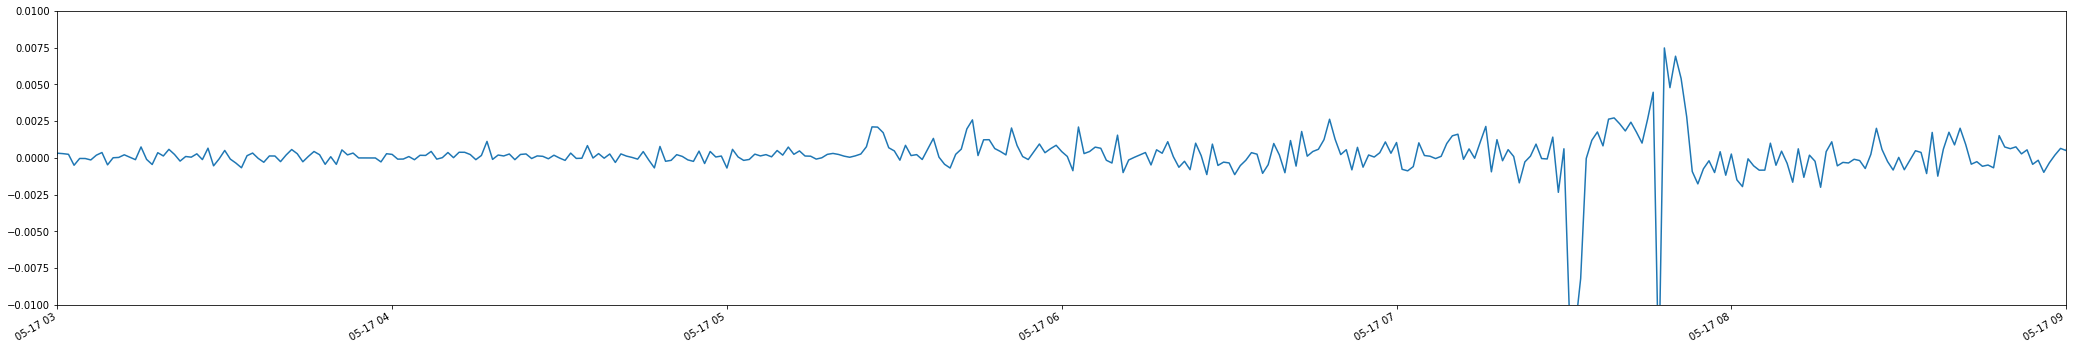

In [138]:
# this is how y(t) looks after adjusting.. 
fig, ax = plt.subplots(1,1, figsize=(36,6))
train.cwshdr.plot(ax=ax)
ax.set_ylim(-0.01, 0.01)
ax.set_xlim("2017-05-17 03:00", "2017-05-17 09:00")

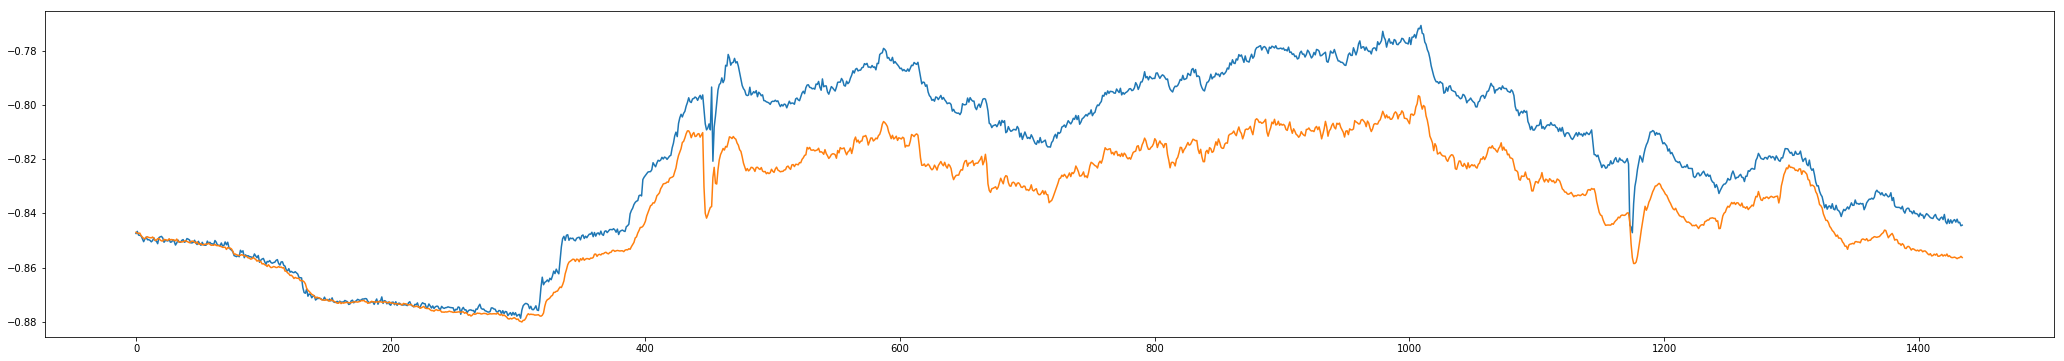

In [139]:
# prediction.. 
fig, ax = plt.subplots(1,1, figsize=(36,6))
ax.plot(y_predict)
ax.plot(y_test)

Notes from above:

1. Seasons are okay. But the trend is again not stationary. Eg: The rolling average (per day) increases during Jan, 2017 for a while and then suddenly goes flat.. The rolling average (per month) is also by not really flat.. why?

## Another approach
Let's remove the trend from data.. and predict

In [424]:
# let's load data freshly
data = df[ ["cwshdr", "loadsys", "drybulb", "ct1kw", "ct2akw", "rh", "cwrhdr", "systotpower", "cwsfhdr"] ].dropna()

# do we want to smooth a bit..
data = data.rolling(3, min_periods=1).mean()

# x(t) = seasons(t) + trends(t) + residual(t)
# We are retrieving residual.. by subtracting trends and seasons. Trends and seasons are identified empirically.
data -= (data.rolling(1*60*24, min_periods=1).mean() - data.rolling(1*60*24*30, min_periods=1).mean())

# normalize data
data = get_normalized_df(data)

# train and test data
train = data["2017-01-07":"2017-01-07"]  # Train on this day
test = data["2017-01-08":"2017-01-08"] # Test on the next day

# fit the model
features = ["drybulb", "rh", "cwsfhdr", "loadsys"]
target = "cwshdr"
reg = linear_model.LinearRegression()
reg.fit(train[features].values, train[target].values)

# check the metrics
y_predict = reg.predict(test[features].values)
y_test = test[target].values

print("MSE: ", metrics.mean_squared_error(y_test, y_predict))
print("Variance score: ", metrics.explained_variance_score(y_test, y_predict), "(1 is the best)")
print("R Squared score: ", reg.score(test[features].values, test[target].values))
print("Error percent: ", mean_absolute_error_percent_noinf(y_test, y_predict))  # 5% or 10% error is where we are looking at.. 

MSE:  0.000554727389355
Variance score:  0.4254081789 (1 is the best)
R Squared score:  0.335353168002
Error percent:  2.05193805049


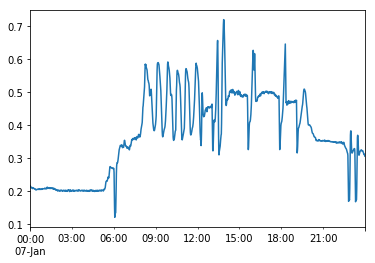

In [425]:
train.loadsys.plot()

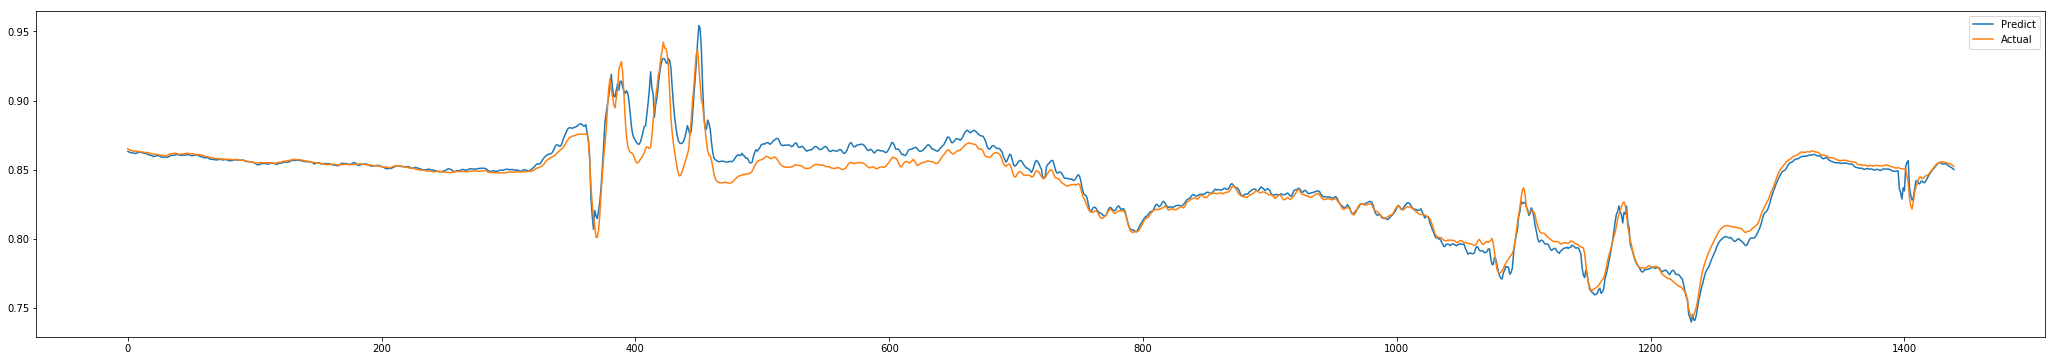

In [369]:
# prediction of the residual..
fig, ax = plt.subplots(1,1, figsize=(36,6))
ax.plot(y_predict, label="Predict")
ax.plot(y_test, label="Actual")
ax.legend()

Hmm.. interesting!!

So, what's this about: http://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html#sphx-glr-auto-examples-gaussian-process-plot-gpr-co2-py Need to learn how this behaves.. 


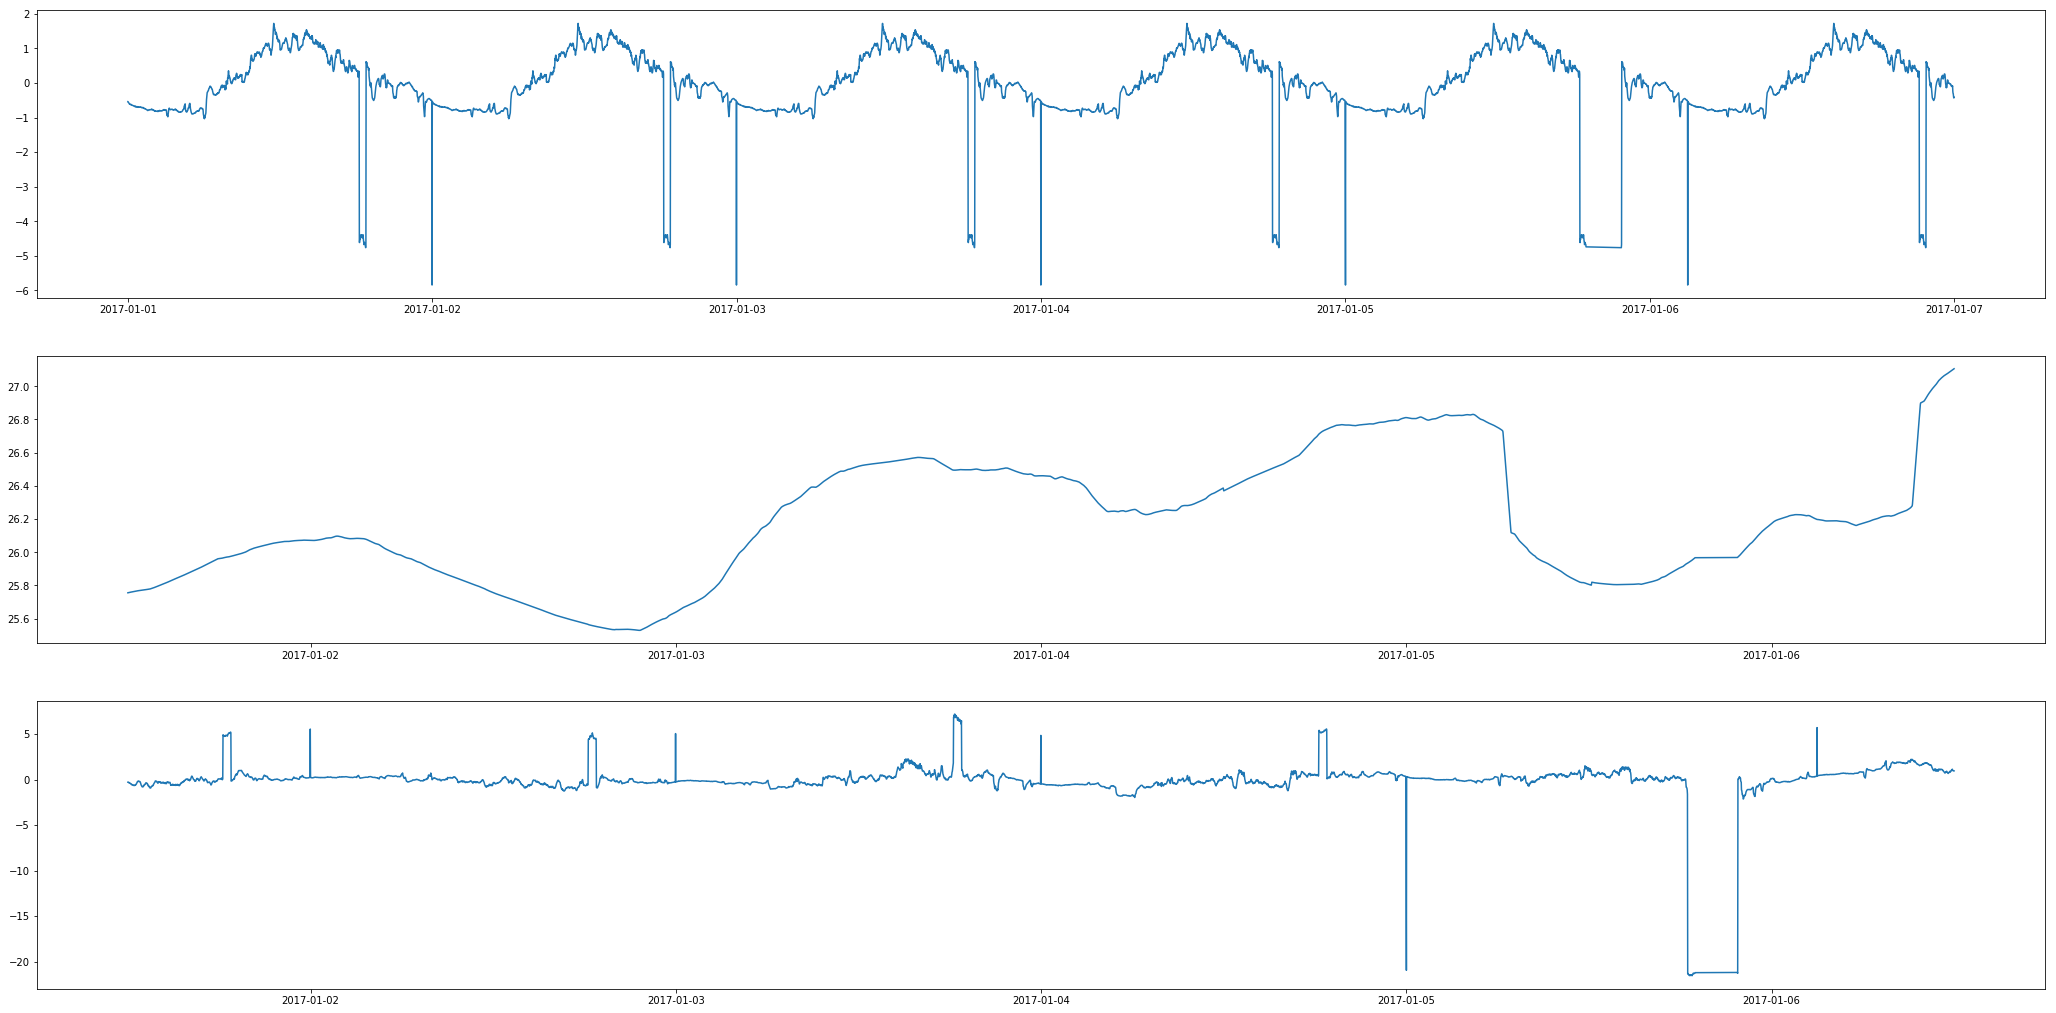

In [423]:
# Let's use statsmodels and decompose. Look into docs the approach these folks take.
import statsmodels.api as sm

data = df[ ["cwshdr", "loadsys", "drybulb", "ct1kw", "ct2akw", "rh", "cwrhdr", "systotpower", "cwsfhdr"] ].dropna()
data = data["2017-01-01":"2017-01-06"]
res = sm.tsa.seasonal_decompose(data.cwshdr, freq=1*60*24, model="additive")

fig, (a1, a2, a3) = plt.subplots(3,1,figsize=(36,6*3))
a1.plot(res.seasonal)
a2.plot(res.trend)
a3.plot(res.resid)

**These sudden zeros are really interfering with everything.. but in general, we have a possible decomposition with residual having near approx. mean.. that's good!!!**

The following are the potential ways we can handle these zeros. All are from an engineering point of view. A statistical view might really help in identifying which of these approaches is bad.

Let's say at $x(t)$ we have a zero. 

1. Fit a linear model with data $x(t-k)$ to $x(t-1)$ and predict $x(t)$. K should be relatively very small.
2. Look back: use $x(t-N)$ where N represents period of the timeseries
3. Mean: Take a window of size K (again small) and replace $x(t)$ with it
4. We can possibly try HMMs here
5. Not do anything. If the zero sequence is long, possibly it means something. However, we can't ignore the observation that zeros are messing up the consecutive predictions (at least in a linear model). Possibly, making them non-zero would help us predicting remaining scenarios better???? 